In [45]:
import pygsti
from pygsti.circuits import Circuit
import random
from pygsti.modelpacks import smq1Q_XYZI as std
# Note that numpy 1.23 will break pygsti
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from forest.benchmarking.operator_tools import vec, unvec

In [46]:
model = std.target_model('CPTP')

In [47]:
from forest.benchmarking.utils import *
from forest.benchmarking.operator_tools import *

class ErrorGen():
    """
    Implements the small Markovian taxonomy
    
    Parameters:
        -features: pauli transfer representations for different error processes
        -rates: sympy vector of rates
    """
    
    def __init__(self, num_qubits, label=('G', 0), parameterization='HSCA'):
        """
        setup the feature dictionary with keys that are sympy variables
        
        right now, I'm doing this by hand for a 1 qubit model, 
        TODO: implement logic to generalize to n-qubits
        """
        self.num_qubits = num_qubits
        self.basis = n_qubit_pauli_basis(num_qubits)
        self.feature_map = dict()
        gate_label = label[0]
        qbit_index = label[1]
        if 'H' in parameterization:
            self.hparams = sp.symbols(
                f'H^{{X{qbit_index}}}_{{{gate_label}}} ' +
                f'H^{{Y{qbit_index}}}_{{{gate_label}}} ' +  
                f'H^{{Z{qbit_index}}}_{{{gate_label}}}')
            self.feature_map[self.hparams[0]] = self.herr('X')
            self.feature_map[self.hparams[1]] = self.herr('Y')
            self.feature_map[self.hparams[2]] = self.herr('Z')
        else:
            self.hparams = []
            
        if 'S' in parameterization:
            self.sparams = sp.symbols(
                f'S^{{X{qbit_index}}}_{{{gate_label}}} ' +
                f'S^{{Y{qbit_index}}}_{{{gate_label}}} ' +  
                f'S^{{Z{qbit_index}}}_{{{gate_label}}}')
            self.feature_map[self.sparams[0]] = self.serr('X')
            self.feature_map[self.sparams[1]] = self.serr('Y')
            self.feature_map[self.sparams[2]] = self.serr('Z')
        else:
            self.sparams = []
            
        if 'C' in parameterization:
            self.cparams = sp.symbols(
                f'C^{{XY{qbit_index}}}_{{{gate_label}}} ' +
                f'C^{{YZ{qbit_index}}}_{{{gate_label}}} ' +  
                f'C^{{ZX{qbit_index}}}_{{{gate_label}}}')
            self.feature_map[self.cparams[0]] = self.cerr('X', 'Y')
            self.feature_map[self.cparams[1]] = self.cerr('Y', 'Z')
            self.feature_map[self.cparams[2]] = self.cerr('Z', 'X')
        else:
            self.cparams = []
            
        if 'A' in parameterization:
            self.aparams = sp.symbols(
                f'A^{{XY{qbit_index}}}_{{{gate_label}}} ' +
                f'A^{{YZ{qbit_index}}}_{{{gate_label}}} ' +  
                f'A^{{ZX{qbit_index}}}_{{{gate_label}}}')
            self.feature_map[self.aparams[0]] = self.aerr('X', 'Y')
            self.feature_map[self.aparams[1]] = self.aerr('Y', 'Z')
            self.feature_map[self.aparams[2]] = self.aerr('Z', 'X')
        else:
            self.aparams = []
            
    @property
    def vec(self):
        return self.hparams+self.sparams+self.cparams+self.aparams
    
    @property
    def mat(self):
        mat = np.zeros((4**self.num_qubits, 4**self.num_qubits), dtype='O')
        for x in self.vec:
            mat += x*self.feature_map[x]
        return sp.Matrix(mat)
    
    @property
    def features(self):
        return [f for f in self.feature_map.values()]
    
    def herr(self, pauli_str):
        """
        hamiltonian error labelled by pauli
        
        Equation (10) in the paper
        """
        pindex = self.basis.labels.index(pauli_str)
        chi_mat = np.zeros((4**len(pauli_str), 4**len(pauli_str)), dtype=complex)
        chi_mat[0, pindex] = 1j
        chi_mat[pindex, 0] = -1j
        return chi2pauli_liouville(chi_mat)
    
    def serr(self, pauli_str):
        """
        stochatic error labelled by pauli
        
        Equation (14) in the paper
        """
        pindex = self.basis.labels.index(pauli_str)
        chi_mat = np.zeros((4**len(pauli_str), 4**len(pauli_str)), dtype=complex)
        chi_mat[0, 0] = -1
        chi_mat[pindex, pindex] = 1
        return chi2pauli_liouville(chi_mat)
    
    def cerr(self, pauli_str1, pauli_str2):
        """
        correlated stochatic error labelled by pair of paulis
        
        Equation (15) in the paper
        """
        pindex1 = self.basis.labels.index(pauli_str1)
        pindex2 = self.basis.labels.index(pauli_str2)
        
        # we also need product terms and their phases
        # this could probably be made more elegant
        pterm1 = str_to_pauli_term(pauli_str1)*str_to_pauli_term(pauli_str2)
        pterm2 = str_to_pauli_term(pauli_str2)*str_to_pauli_term(pauli_str1)
        
        phase1 = pterm1.coefficient
        phase2 = pterm2.coefficient
        pid1 = pterm1.id()
        pid2 = pterm1.id()
        # need to fix the id convention that pyquil uses
        # discard the even indices
        pid1 = [ele for idx, ele in enumerate(pid1) if idx % 2 == 0]
        pid2 = [ele for idx, ele in enumerate(pid2) if idx % 2 == 0]
        prod_index1 = self.basis.labels.index(''.join(pid1))
        prod_index2 = self.basis.labels.index(''.join(pid2))

        chi_mat = np.zeros((4**self.num_qubits, 4**self.num_qubits), dtype=complex)
        chi_mat[pindex1, pindex2] += 1
        chi_mat[pindex2, pindex1] += 1
        # include the terms 
        # PQrII + QPrII + IIrPQ + IIrQP
        chi_mat[prod_index1, 0] += -0.5*phase1
        chi_mat[prod_index2, 0] += -0.5*phase2
        chi_mat[0, prod_index1] += -0.5*phase1
        chi_mat[0, prod_index2] += -0.5*phase2
        return chi2pauli_liouville(chi_mat)
    
    def aerr(self, pauli_str1, pauli_str2):
        """
        active error labelled by pair of paulis
        
        Equation (16) in the paper
        """
        pindex1 = self.basis.labels.index(pauli_str1)
        pindex2 = self.basis.labels.index(pauli_str2)
        
        # we also need product terms and their phases
        # this could probably be made more elegant
        pterm1 = str_to_pauli_term(pauli_str1)*str_to_pauli_term(pauli_str2)
        pterm2 = str_to_pauli_term(pauli_str2)*str_to_pauli_term(pauli_str1)
        
        phase1 = pterm1.coefficient
        phase2 = pterm2.coefficient
        pid1 = pterm1.id()
        pid2 = pterm1.id()
        # need to fix the id convention that pyquil uses
        # discard the even indices
        pid1 = [ele for idx, ele in enumerate(pid1) if idx % 2 == 0]
        pid2 = [ele for idx, ele in enumerate(pid2) if idx % 2 == 0]
        prod_index1 = self.basis.labels.index(''.join(pid1))
        prod_index2 = self.basis.labels.index(''.join(pid2))

        chi_mat = np.zeros((4**self.num_qubits, 4**self.num_qubits), dtype=complex)
        chi_mat[pindex1, pindex2] += 1j
        chi_mat[pindex2, pindex1] += -1j
        # include the terms 
        # PQrII - QPrII + IIrPQ - IIrQP
        chi_mat[prod_index1, 0] += 0.5j*phase1
        chi_mat[prod_index2, 0] += -0.5j*phase2
        chi_mat[0, prod_index1] += 0.5j*phase1
        chi_mat[0, prod_index2] += -0.5j*phase2
        return chi2pauli_liouville(chi_mat)

In [48]:
class GateSet():
    """
    Holds the information for
        -all native gates, states, and measurements
        -all error generator features (in a feature dict)
        -map between gate labels and parameter index list (index set)
        -map between parameter indices and error features (feature dict) 
        
    TODO: generalize to n-qubits
    """
    def __init__(self, model_pack, parameterization='HSCA'):
        # A list of error rates, each one corresponding to one feature in the above list
        self.rates = []
        self.feature_map = dict() # maps variables to their associated feature
        self.egen_from_label = dict() # maps gate labels to error generators
        self.target_model = model_pack.target_model('CPTP')
        self.gate_labels = model_pack.gates
        
        # Errors generators for all gates in the model
        for gate in model_pack.gates:
            if len(gate) <= 1:
                egen = ErrorGen(1, (gate, ''))
            else:
                egen = ErrorGen(1, gate)
            self.egen_from_label[gate] = egen
            self.rates += egen.vec
            self.feature_map.update(egen.feature_map)
        # Errors for all measurements in the model
        for povm in model.povms.keys():
            egen = ErrorGen(1, (povm, 'M'))
            self.egen_from_label[povm] = egen
            self.rates += egen.vec
            self.feature_map.update(egen.feature_map)
        # Errors for all state preparations in the model
        for prep in model.preps.keys():
            egen = ErrorGen(1, (prep, 'P'))
            self.egen_from_label[prep] = egen
            self.rates += egen.vec
            self.feature_map.update(egen.feature_map)
            
    @property
    def vec(self):
        return self.rates
    
    def features_of(self, op_label):
        """Returns the list of error features associated with the given gate/POVM/state-prep"""
        return self.egen_from_label[op_label].features
    
    def rates_of(self, op_label):
        """Returns the list of error rates associated with the given gate/POVM/state-prep"""
        return self.egen_from_label[op_label].vec
    
    def error_generator_of(self, op_label):
        """Returns the error generator matrix associated with the given gate/POVM/state-prep"""
        return self.egen_from_label[op_label].mat
    
    def target_op(self, op_label):
        """
        returns the target operation of the given operation
        """
        return self.target_model[op_label].to_dense()

    def native_meas(self):
        return [m.to_dense() for m in self.target_model['Mdefault'].values()]

    def rho0(self):
        return self.target_model['rho0'].to_dense()


In [205]:
class CircuitAnalyzer:
    """Performs operations on a given pygsti Circuit object,
    which is part of a given GateSet.
    
    The Circuit's state prep and measurement operators are set to the default values,
    but can be specified by their names, as long as they are part of the GateSet."""
    def __init__(self, circuit, gateset, state_prep="rho0", povm="Mdefault"):
        self.gateset = gateset
        self.circuit = circuit
        # Extracts the gates in the circuit as a list of labels
        # This may only work for sngle-qubit gates as written?
        self.gates = list(circuit.layertup)
        # Finds their PTMs (pauli transfer matrices)
        self.gate_matrices = [gateset.target_op(gate) for gate in self.gates]
        # Extracts the error matrices corresponding to each of these gates
        self.gate_errors = [gateset.error_generator_of(gate) for gate in self.gates]
        ## TODO extract the circuit's POVM and State Prep, to find their associated errors
        self.state_prep_error = gateset.error_generator_of(state_prep)
        self.povm_error = gateset.error_generator_of(povm)
        
    def left_errors(self):
        """Moves all gate errors to the left of the circuit,
        and returns the resulting list of conjugated error generators.
        
        NOTE: In our Circuit object, the gates are ordered
        left-to-right from first-applied to last-applied.
        However, the error terms in the result of this function, are ordered
        left-to-right as they would be in matrix multiplication."""
        
        left_errors = []
        # The first error in the result is the measurement error,
        # which is unchanged (doesn't need conjugating)
        left_errors.append(self.povm_error)
        # Next, process the gate errors from the end of the list to its beginning
        # Because that's the order they'll appear in the resulting matrix mult
        n = len(self.gate_errors)
        for i in range(n-1, -1, -1):
            error = self.gate_errors[i]
            # Conjugate by all gates being applied after i: gates i+1 through n
            for j in range(i+1, n):
                gate_matrix = self.gate_matrices[j].round(10)
                error = gate_matrix * error * np.linalg.inv(gate_matrix)
            left_errors.append(error)
        # Finally, add the State prep error;
        # We must conjugate it through all gates in the circuit
        error = self.state_prep_error
        for j in range(n):
            gate_matrix = self.gate_matrices[j].round(10)
            error = gate_matrix * error * np.linalg.inv(gate_matrix)
        left_errors.append(error)
        return left_errors
    
    def linear_F_map(self):
        """Returns the linear approximation of the F map,
        after moving all errors to the left. This approximation assumes they commute.
        The result is a function of the error terms of the gate set.
        """
        # Simply take the sum of all error generators after moving them to the left
        left_errors = self.left_errors()
        return sum(left_errors[1:], left_errors[0])
    
    def order2_F_map(self):
        """Returns the order-2 approximation of the F map,
        after moving all errors to the left, and applying order-2 BCH.
        The result is a function of the error terms of the gate set.
        """
        left_errors = self.left_errors()
        BCH2 = lambda X, Y : X + Y + (X@Y - Y@X) / 2
        # After extracting the left-side errors,
        # reduce the list to one matrix by applying BCH to each pair
        result = left_errors[0]
        for F in left_errors[1:]:
            result = sp.expand(BCH2(result, F))
        return result
    
    def linear_op(self):
        """
        convert the linear left feature map into 
        a linear operator that maps gateset features to total circuit features

        TODO: more efficient design
        TODO: rewrite in terms of HSCA parameterization
        """
        dim = 4**self.circuit.width # dimension of the hilbert space
        lop = np.zeros((dim*(dim-1), len(self.gateset.vec)))
        fmap = self.linear_F_map()
        for i in range(1, dim):
            for j in range(0, dim):
                for idx, x in enumerate(self.gateset.vec):
                    lop[(i-1)*dim+j, idx] = fmap[i, j].coeff(x)
        return lop

## the linear feature design:

The left or right F-matrix can be viewed as an operator from the high dimensional space of the vectorized gateset to the lower dimensional space of the total circuit error feature

In [206]:
# Create a simple two gate circuit
gs = GateSet(std)
circ = Circuit([("Gxpi2", 0), ("Gzpi2", 0)])
ca = CircuitAnalyzer(circ, gs)

In [207]:
len(ca.left_errors())

4

In [208]:
ca.linear_F_map()

Matrix([
[                                                                                       0,                                                                                                                                                                              0,                                                                                                                                                                              0,                                                                                                                                                                              0],
[-4.0*A^{XYP}_{rho0} - 4.0*A^{YZ0}_{Gzpi2} - 4.0*A^{YZM}_{Mdefault} + 4.0*A^{ZX0}_{Gxpi2},     -2.0*S^{X0}_{Gxpi2} - 2.0*S^{XP}_{rho0} - 2.0*S^{Y0}_{Gzpi2} - 2.0*S^{YM}_{Mdefault} - 2.0*S^{YP}_{rho0} - 2.0*S^{Z0}_{Gxpi2} - 2.0*S^{Z0}_{Gzpi2} - 2.0*S^{ZM}_{Mdefault}, -2.0*C^{XY0}_{Gxpi2} + 2.0*C^{XY0}_{Gzpi2} + 2.0*C^{XYM}_{Mdefault} + 2.0*C^{ZXP}_{rho0} - 2.0*H^{YP}_{r

In [209]:
# do NOT DISPLAY the result. it's huge. It will crash the notebook due to Latex formatting.
order2 = ca.order2_F_map()

In [210]:
# Here's how long each entry is, as a string
for i in range(1, 4):
    for j in range(4):
        print(len(str(order2[i, j])))

89051
23010
78674
78673
89052
78673
23009
78673
89052
78673
78674
23010


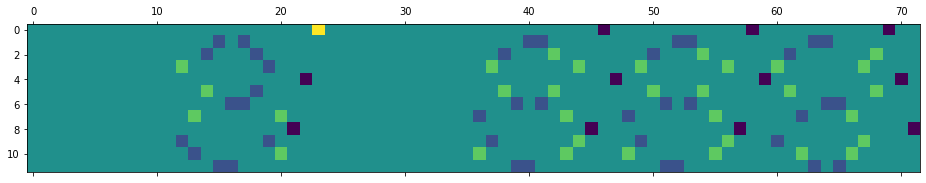

In [180]:
plt.matshow(ca.linear_op());

# Total feature design

I'll create a simple experimental design consisting of some repeated germs and then I'll find the total feature design that comes from stacking up each circuit's feature design. The nullspace of this opeartor gives information about gauge transformations

In [181]:
edesign = std.create_gst_experiment_design(1) # max length of edesign is 2
circ_list = edesign.circuit_lists[-1]
len(circ_list)

128

In [182]:
from tqdm import tqdm
total_lop = np.zeros((0, len(gs.vec)))
for circ in tqdm(circ_list[1:]):
    ca = CircuitAnalyzer(circ, gs)
    total_lop = np.vstack([total_lop, ca.linear_op()])

100%|██████████| 127/127 [00:23<00:00,  5.40it/s]


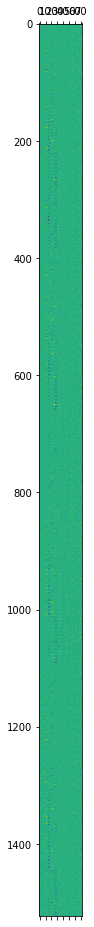

In [183]:
plt.matshow(total_lop)

In [184]:
np.linalg.matrix_rank(total_lop)

60